In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc
import regex as re
import scipy.stats as stats
from itertools import combinations

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp
import functions_plotting as dplt
import functions_for_CAR_annotation as ca
import functions_OVA_annotation as oa

/tmp/ipykernel_157953/666125554.py:21: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [77]:
#if needed, reload functions
import importlib
importlib.reload(dp)
importlib.reload(dplt)
importlib.reload(ca)
importlib.reload(oa)

<module 'functions_OVA_annotation' from '/home/s377963/car_t_sc/02_code/functions/functions_OVA_annotation.py'>

# Load Data

In [5]:
#import data

# adata_raw = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_raw_demultiplexed.h5ad') 
# adata_qc = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc.h5ad')
# adata_TIL_only = adata_qc[adata_qc.obs.Location != 'dLN']
# adata_pureTC = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation.h5ad') 
# adata_only_pureTC = adata_pureTC[adata_pureTC.obs['is.pure_Tcell'] == 'Pure']
adata_pure_TC_annotated = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation_non_TC_filtered_TC_subtypes_annotated.h5ad') 
adata_only_annotatedTC = adata_pure_TC_annotated[~adata_pure_TC_annotated.obs['functional.cluster'].isna()]

In [6]:
non_annotated = [adata_pure_TC_annotated, adata_only_annotatedTC]

In [7]:
for adata in non_annotated:
    adata.obs.rename(columns={"HTO_classification": "Classification"}, inplace=True) 
    adata.obs.rename(columns={"functional.cluster": "Tcell_subtype"}, inplace=True)
    adata.obs.rename(columns={"pool": "dataset"}, inplace=True)
    rmvd_p = [int(dataset.replace("P", "")) - 1 for dataset in adata.obs['dataset']]
    adata.obs['dataset'] = rmvd_p

/tmp/ipykernel_157953/939101785.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dataset'] = rmvd_p


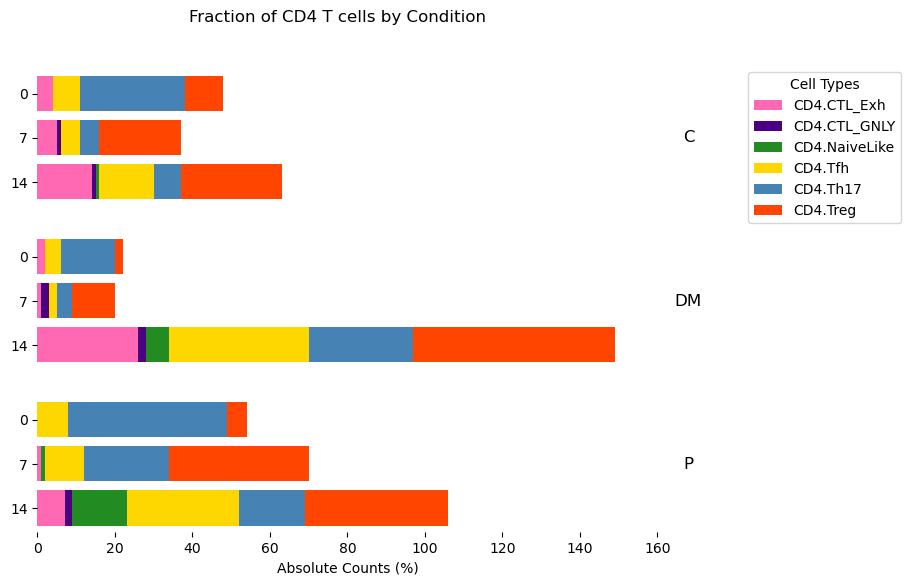

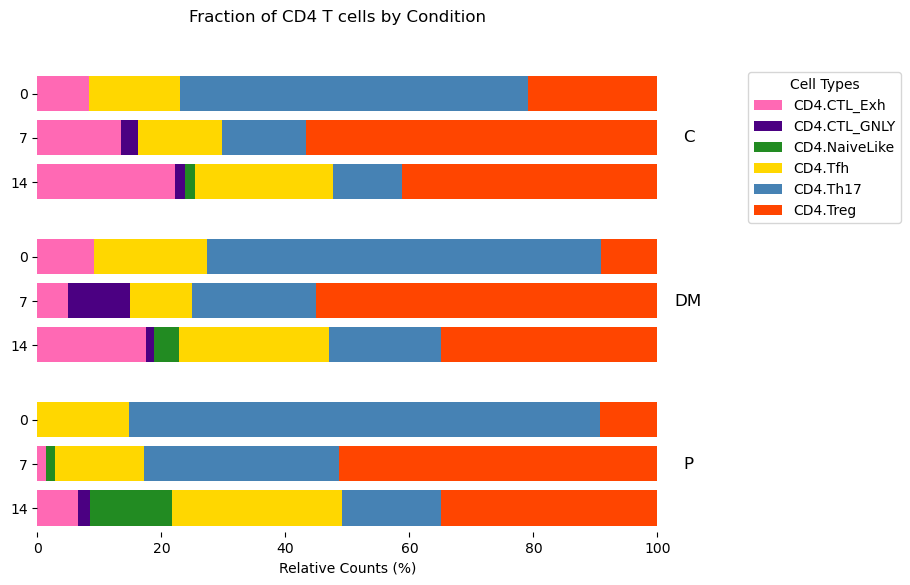

In [ ]:
# for the abs filtered HTODemux data (exactly like calagry)
dplt.stacked_barplot(adata_only_annotatedTC, 'CD4', 'Tcell_subtype', 160, xlabel='Absolute Counts (%)', norm=False)
dplt.stacked_barplot(adata_only_annotatedTC, 'CD4', 'Tcell_subtype', 100, xlabel='Relative Counts (%)')

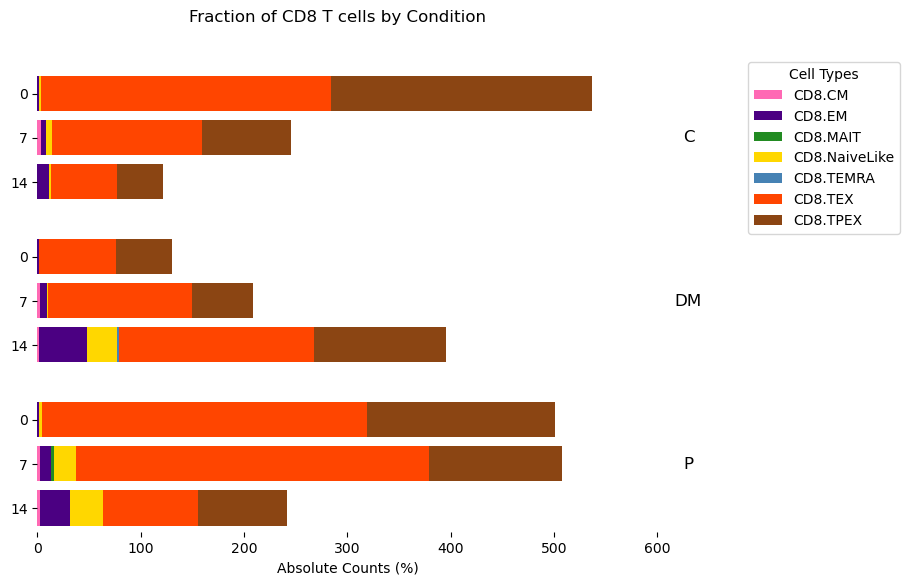

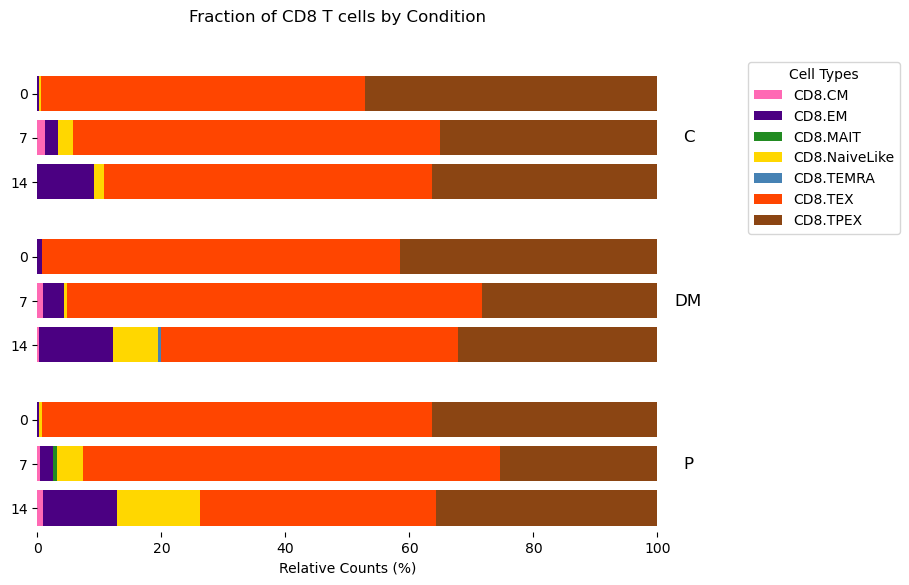

In [ ]:
# for the abs filtered HTODemux data (exactly like calagry)
dplt.stacked_barplot(adata_only_annotatedTC, 'CD8', 'Tcell_subtype', 600, xlabel='Absolute Counts (%)', norm=False)
dplt.stacked_barplot(adata_only_annotatedTC, 'CD8', 'Tcell_subtype', 100, xlabel='Relative Counts (%)')

# Determine cytokine profile

In [25]:
adata_only_annotatedTC.obs.condition
# adata_only_annotatedTC.obs.day

AAACCTGCATGAAGTA-1_1     C
AAACCTGGTAGGACAC-1_1    DM
AAACGGGAGAAACCTA-1_1     C
AAACGGGAGCAACGGT-1_1     P
AAAGCAAAGGTGATTA-1_1    DM
                        ..
TTGCGTCTCAAGAAGT-1_9    DM
TTGGAACGTTAAGTAG-1_9     P
TTTATGCGTCTTGCGG-1_9    DM
TTTATGCTCCACGCAG-1_9     P
TTTGGTTTCCAAAGTC-1_9     C
Name: condition, Length: 3456, dtype: category
Categories (3, object): ['C', 'DM', 'P']

In [48]:
# Comprehensive list of cytokines categorized by function
cytokine_genes = [
    # Pro-Inflammatory Cytokines
    "Il1a", "Il1b", "Il18", "Il33", "Il36a", "Il36b", "Il36g", "Il37", "Il38",
    "Tnf", "Lta", "Baff", "April", "Il6", "Il17a", "Il17b", "Il17c", "Il17d", "Il17e", "Il17f",
    "Il12a", "Il12b", "Il23a", "Il27", "Il35",
    
    # Anti-Inflammatory Cytokines
    "Il10", "Tgfb1", "Tgfb2", "Tgfb3", "Il35",
    
    # Chemokines (CC family)
    "Ccl1", "Ccl2", "Ccl3", "Ccl4", "Ccl5", "Ccl7", "Ccl8", "Ccl11", "Ccl13",
    "Ccl17", "Ccl18", "Ccl19", "Ccl20", "Ccl21", "Ccl22", "Ccl25", "Ccl27",
    
    # Chemokines (CXC family)
    "Cxcl1", "Cxcl2", "Cxcl3", "Cxcl5", "Cxcl8", "Cxcl9", "Cxcl10", "Cxcl11",
    "Cxcl12", "Cxcl13", "Cxcl16",
    
    # Other Chemokines
    "Xcl1", "Xcl2", "Cx3cl1",
    
    # Interferons
    "Ifna1", "Ifna2", "Ifna4", "Ifna5", "Ifna6", "Ifna7", "Ifna9", "Ifna10", "Ifna11", "Ifna13",
    "Ifnb1", "Ifne", "Ifnk", "Ifnw1",
    "Ifng",
    "Ifnl1", "Ifnl2", "Ifnl3",
    
    # Growth Factors
    "Csf2", "Csf3", "Csf1", "Egf", "Vegfa", "Vegfb", "Vegfc", "Fgf1", "Fgf2",
    "Pdgfa", "Pdgfb", "Pdgfc", "Pdgfd", "Hgf", "Igf1", "Igf2",
    
    # T Cell-Derived Cytokines
    "Il2", "Il4", "Il5", "Il9", "Il13", "Il21", "Il22", "Il25",
    
    # Regulatory (Treg)
    "Il10", "Tgfb1", "Tgfb2", "Tgfb3", "Il35",
    
    # Other Cytokines
    "Spp1", "Il24", "Il26"
]

# If you just need a flat list of all cytokines:
# all_cytokines = sum([v if isinstance(v, list) else sum(v.values(), []) for v in cytokines.values()], [])

# Print all cytokines
# print(all_cytokines)


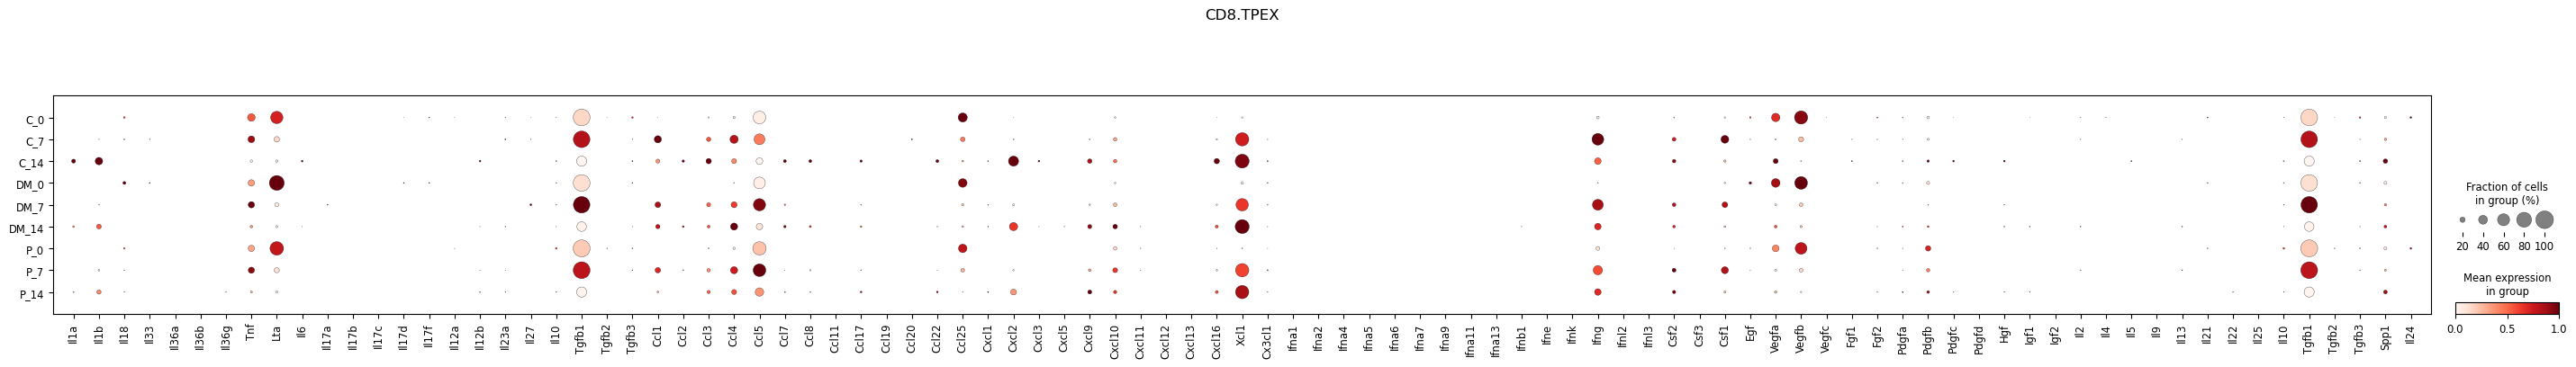

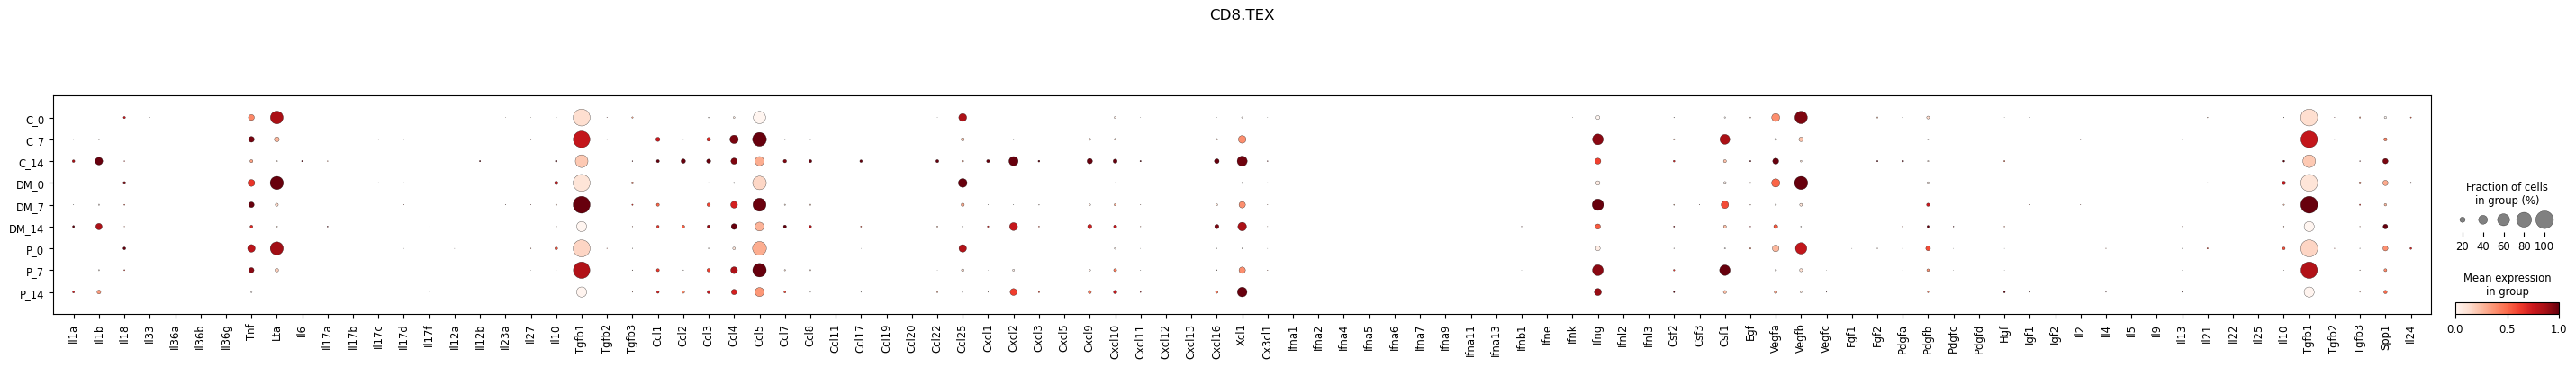

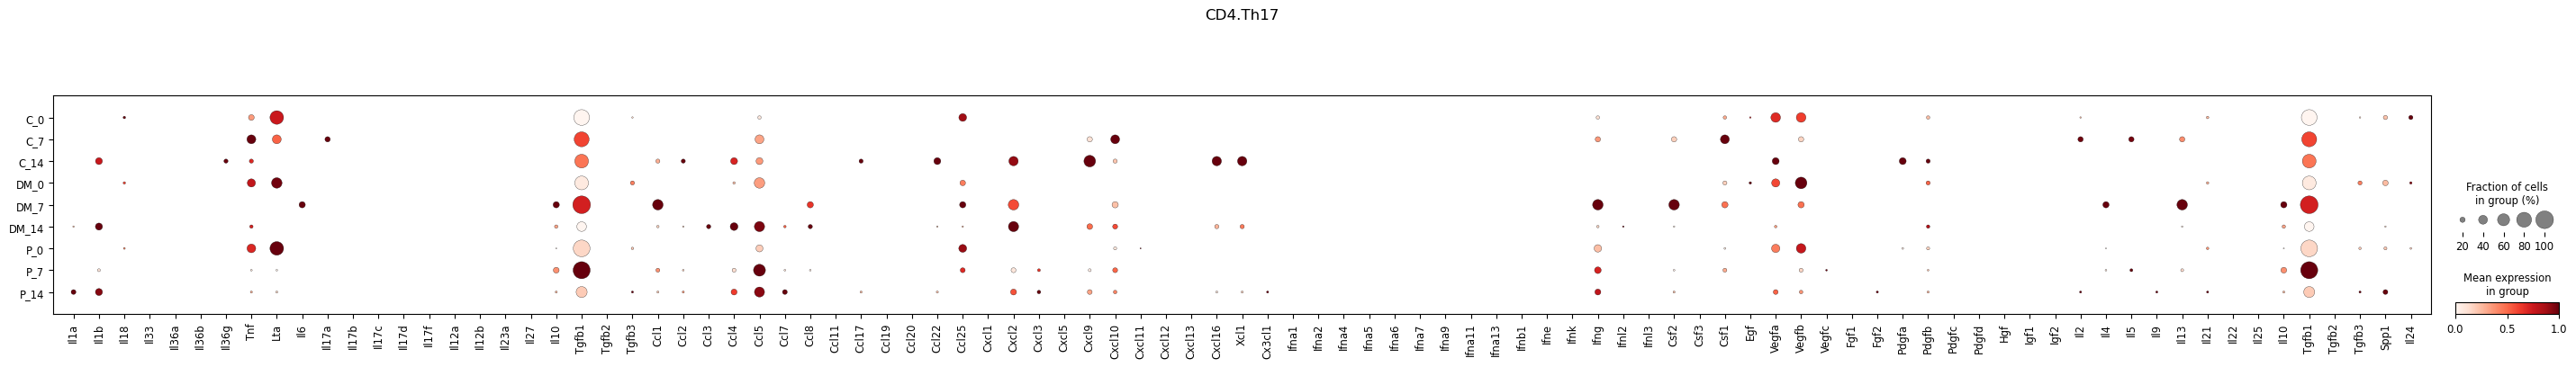

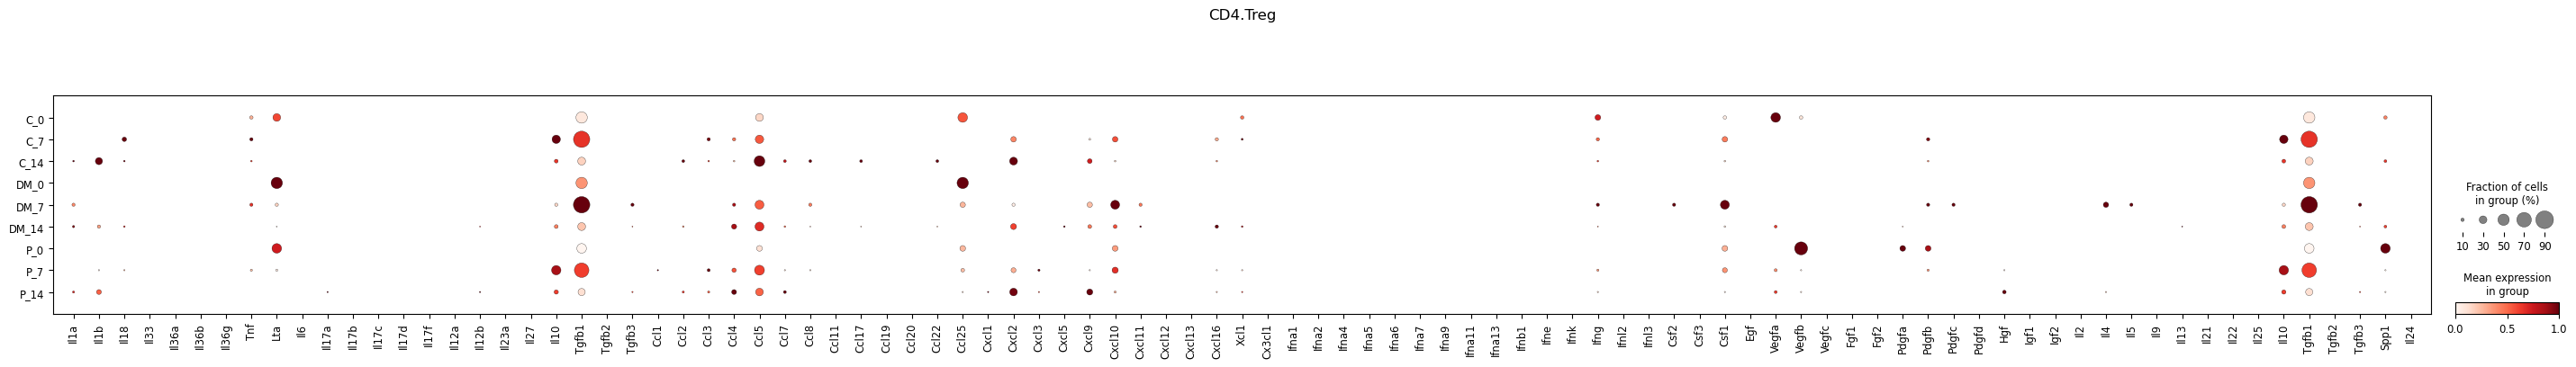

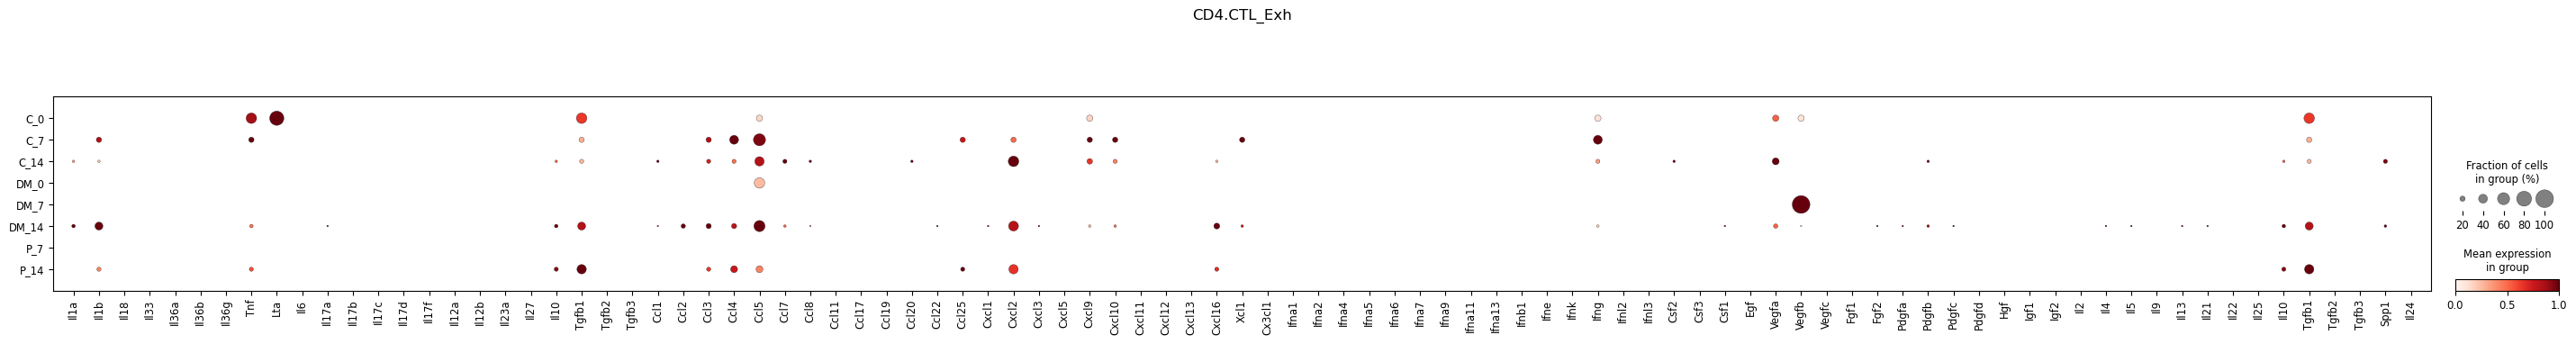

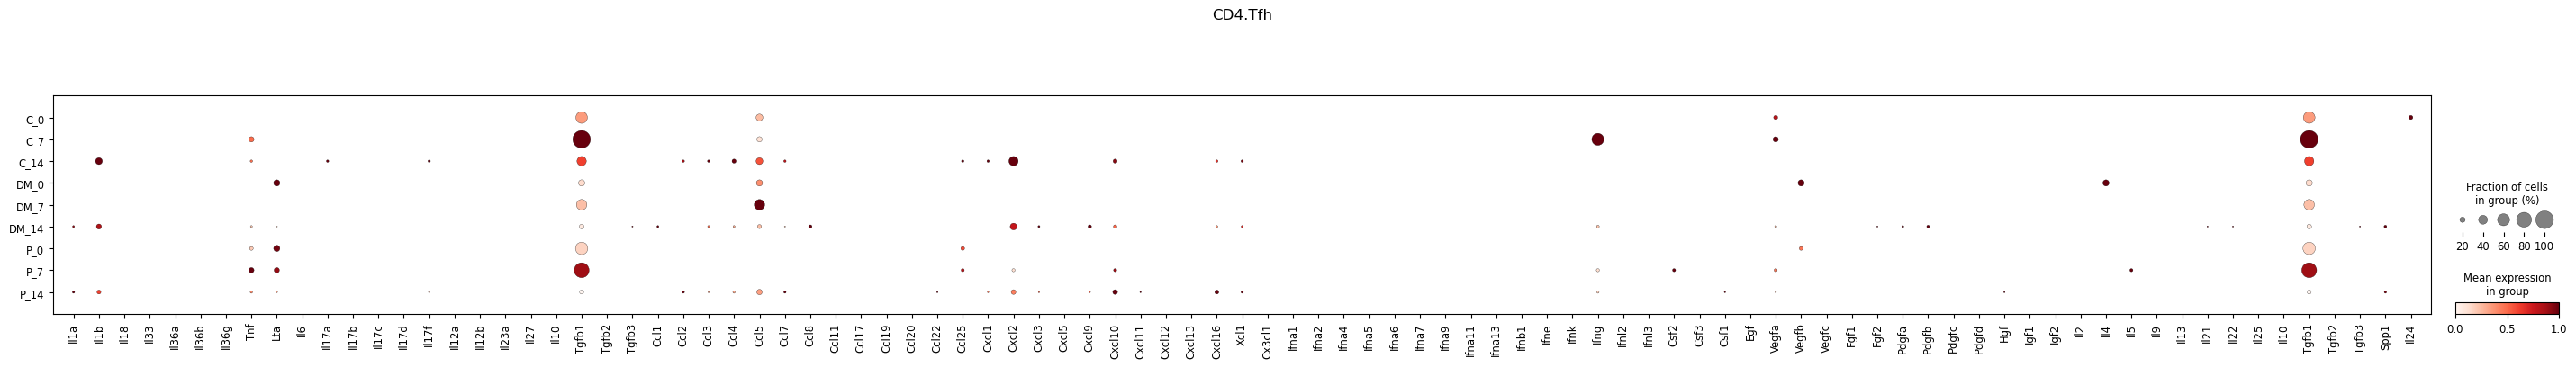

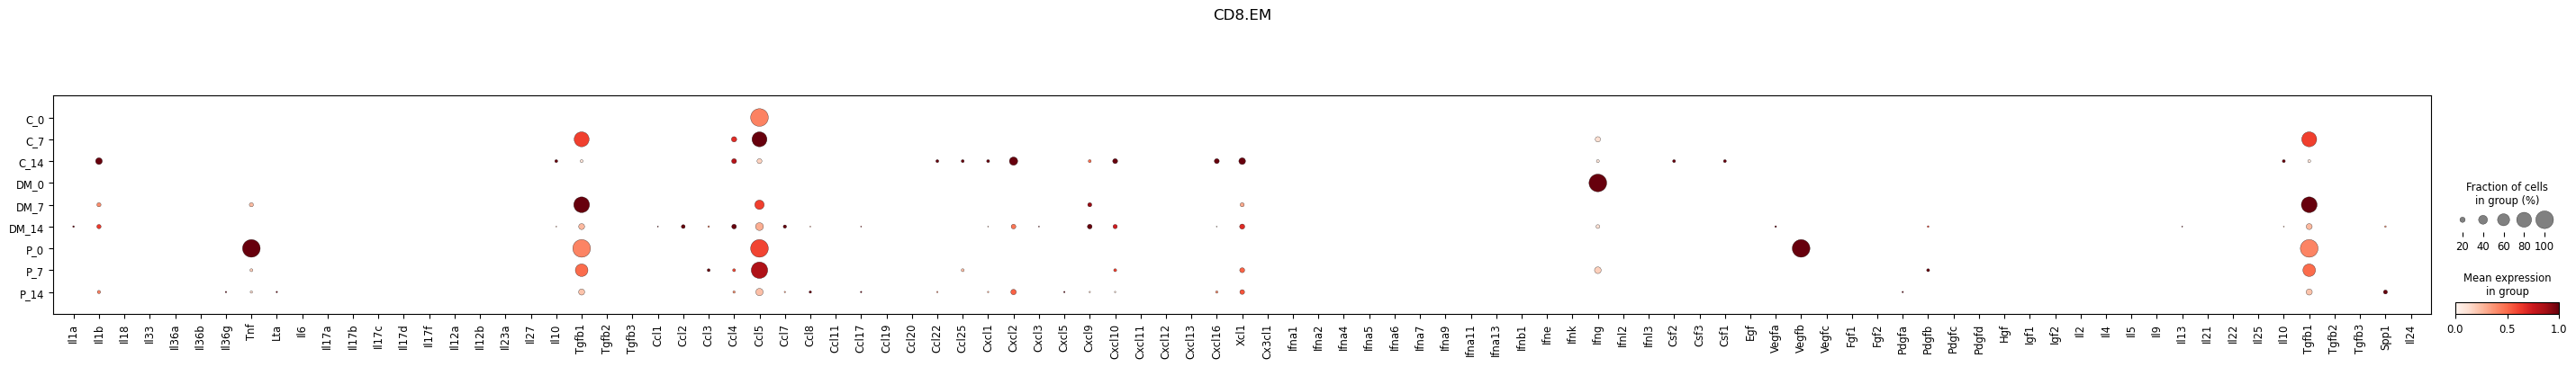

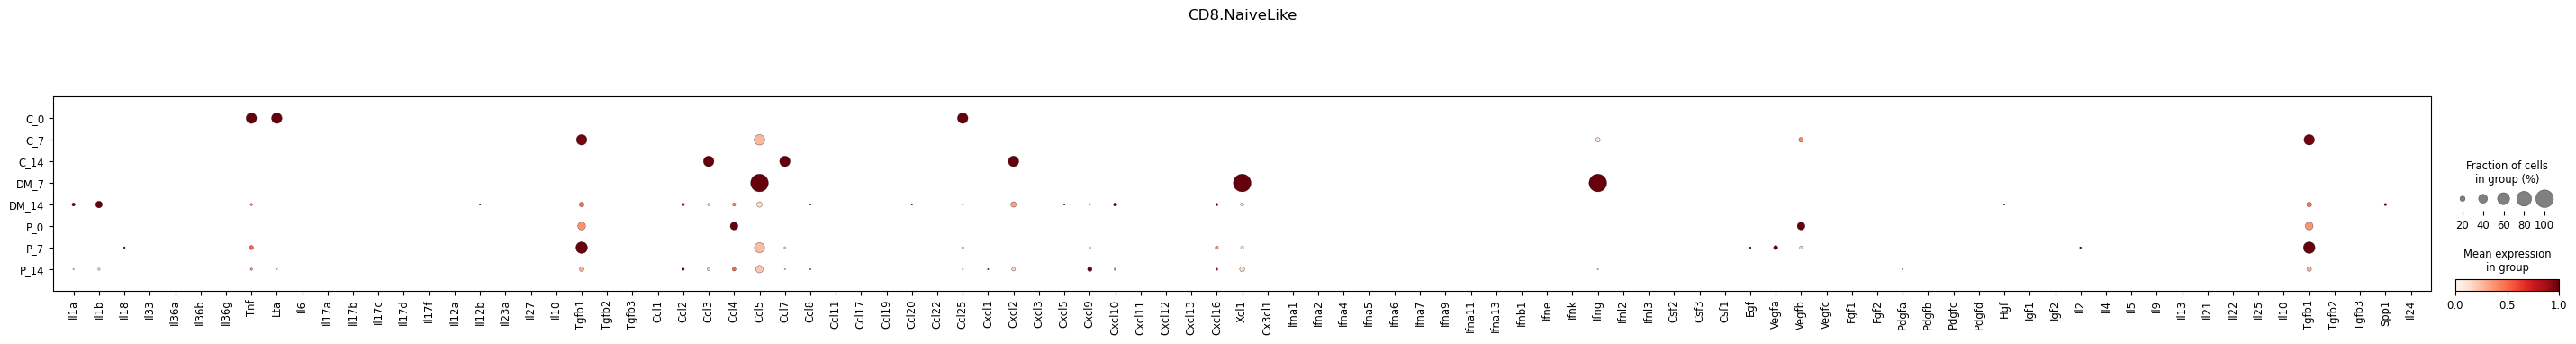

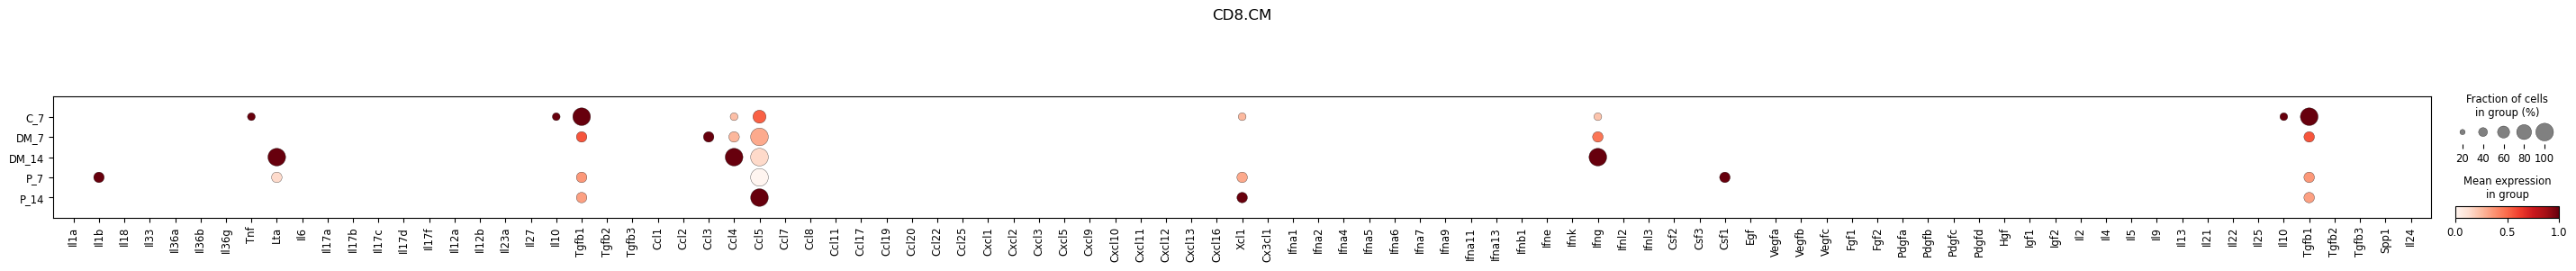

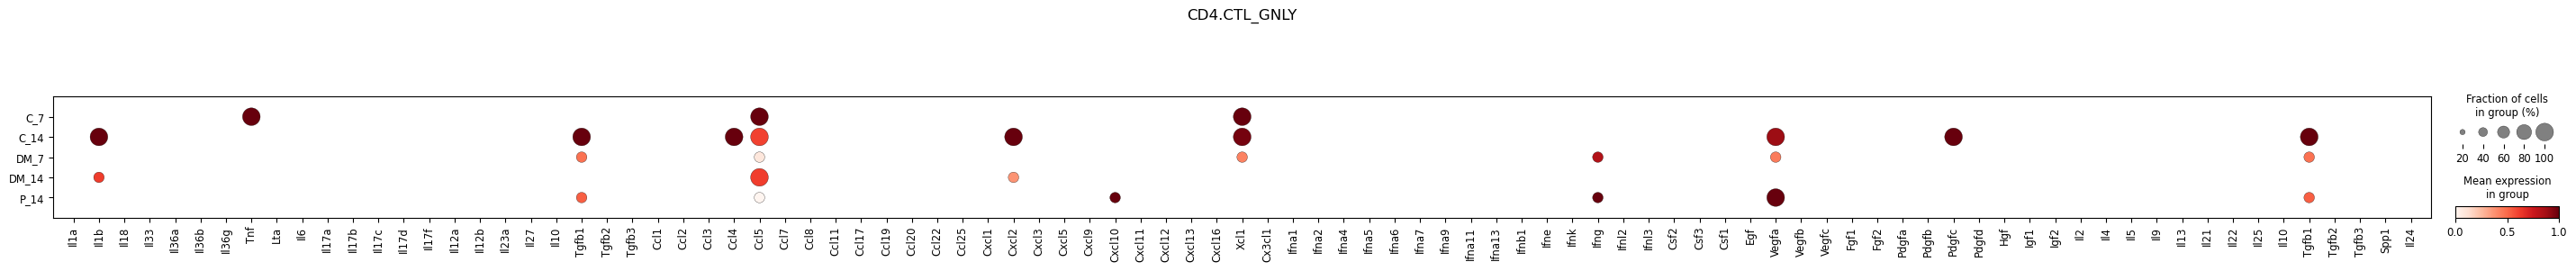

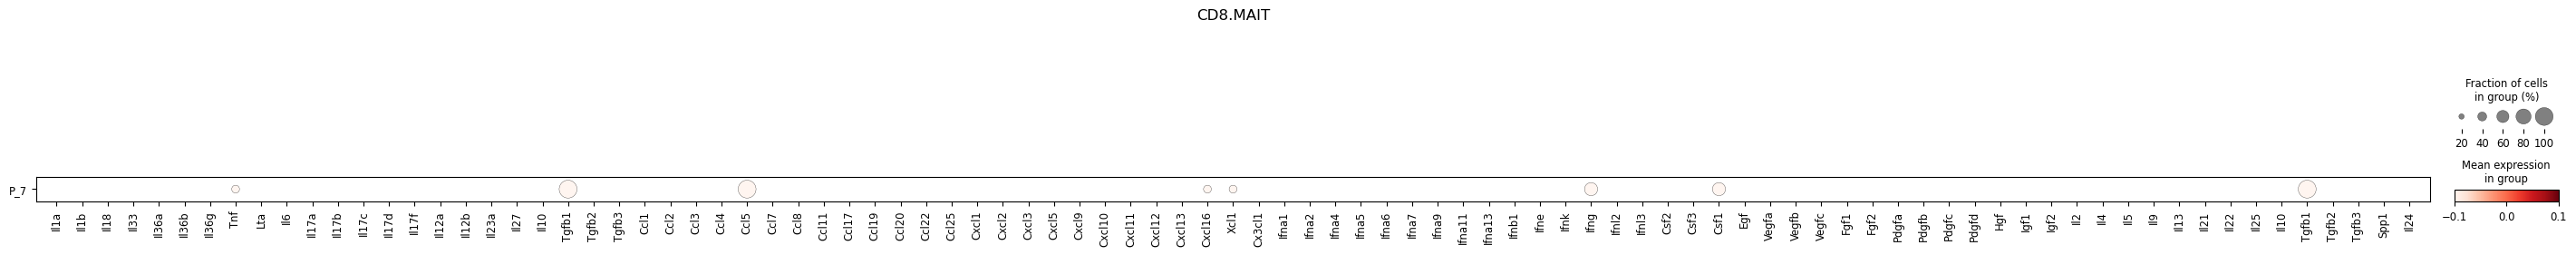

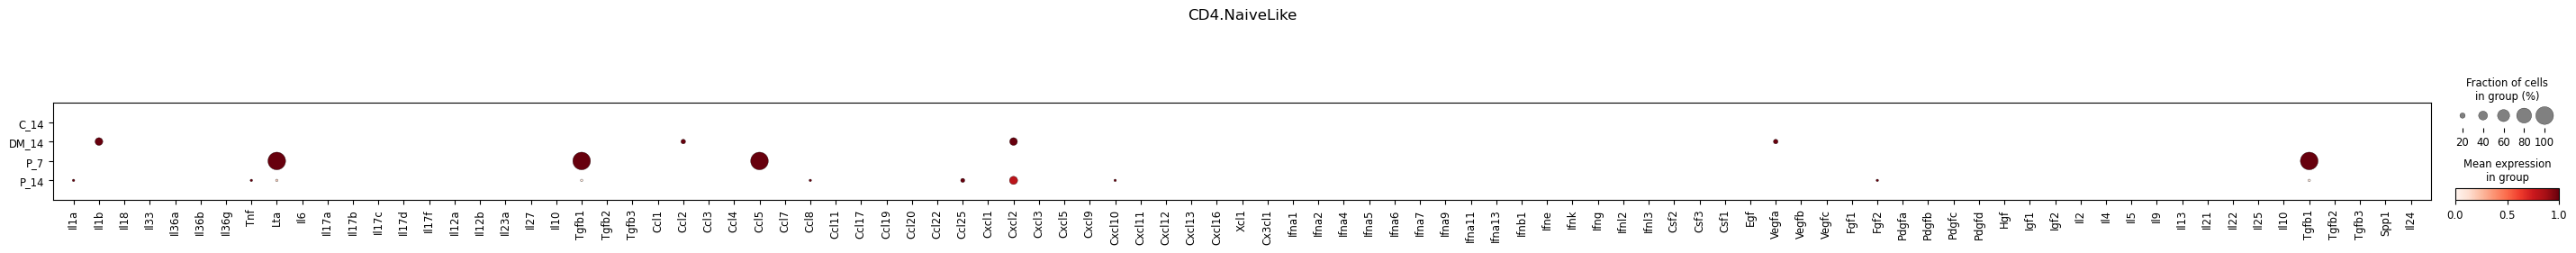

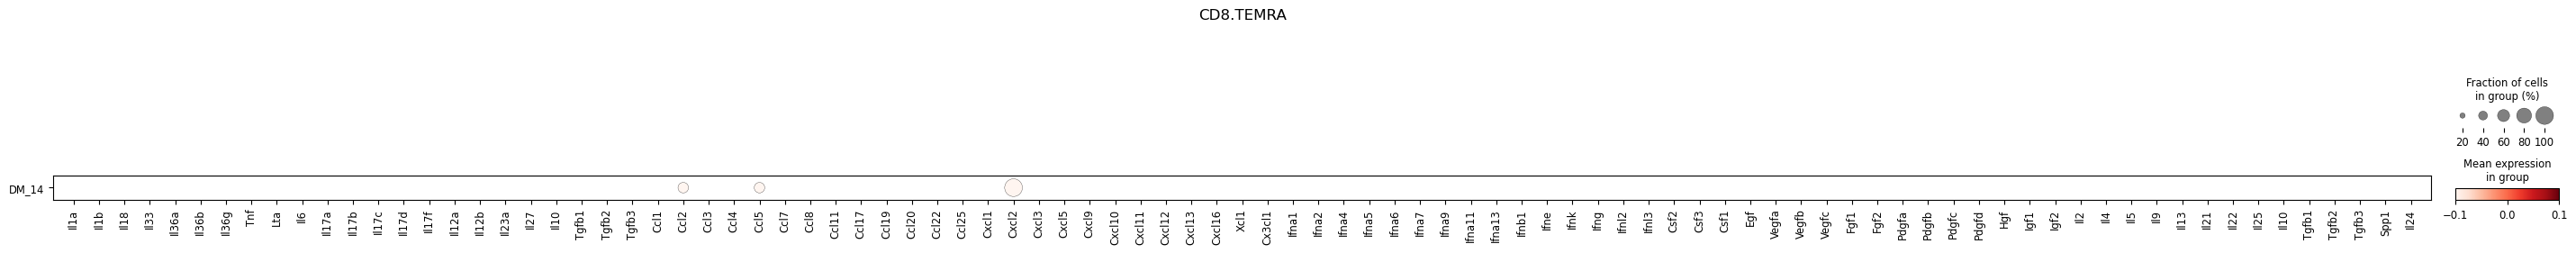

In [51]:
adata_only_annotatedTC.obs.Tcell_subtype
# var = ["Il2", "Ifng", "Tnf", "Il4", "Il10", "Il17a"]
# var = cytokines['Pro_Inflammatory']
subtypes = adata_only_annotatedTC.obs.Tcell_subtype.unique()

for subtype in subtypes:
    adata = adata_only_annotatedTC[adata_only_annotatedTC.obs.Tcell_subtype == subtype].copy()
    cytokines_in_adata = [gene for gene in cytokine_genes if gene in adata.var_names]
    sc.pl.dotplot(adata, cytokines_in_adata, groupby=["condition", "day"], standard_scale="var", swap_axes=False, cmap="Reds", title=subtype)